In [15]:
import pandas as pd
import glob
import json
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns

In [16]:
resultdir = "/data/mtmoore/school/CSiML_AI395T/final_project/models/yolo11/iterative"
trainre = re.compile(r'^.+\/iterative\/(?P<modelname>[^_]+)_(?P<imgsz>[\d]+)imgsz_(?P<camera>[^_]+)_(?P<epochs>[\d]+)epochs$')

model_parent = "yolov"
train_df = pd.DataFrame()

for trainresult in glob.glob(f"{resultdir}/*epochs"):
    match = trainre.match(trainresult)
    if match is None:
        print(F"didn't match directory name {trainresult}")
        continue
    params = match.groupdict()
    new_result = params.copy()
    new_result['modelname'] = f"{model_parent}{new_result['modelname']}"

    if not os.path.exists(f"{trainresult}/results.csv"):
        print(f"{trainresult}/results.csv doesn't exist right now, skipping")
        continue
    
    df = pd.read_csv(f"{trainresult}/results.csv")
    df['imgsz'] = new_result['imgsz']
    df['max_epochs'] = new_result['epochs']
    df['camera'] = new_result['camera']
    df['modelname'] = new_result['modelname']
    df = df.astype({'epoch':'int', 
                    'time': 'float', 
                    'train/box_loss': 'float', 
                    'train/cls_loss': 'float',
                    'train/dfl_loss': 'float',
                    'metrics/recall(B)': 'float',
                    'metrics/mAP50-95(B)': 'float',
                    'val/box_loss': 'float',
                    'val/cls_loss': 'float',
                    'val/dfl_loss': 'float',
                    'lr/pg0': 'float',
                    'lr/pg1': 'float',
                    'lr/pg2': 'float',
                    'imgsz': int,
                    'max_epochs': int,
                   })
    df.dropna(subset=['train/box_loss', 'train/cls_loss', 'train/dfl_loss'], inplace=True)
    train_df = pd.concat([train_df, df])

In [25]:
#pd.set_option('display.max_rows', None)
pd.reset_option('^display.', silent=True)

train_df.rename(columns={'imgsz': "Image Size (px)", 'epoch': 'Epoch',
#                       'precision': 'Precision', 'recall': 'Recall',
                         'camera': 'Camera', 'modelname': 'Model Name',
                         'train/box_loss': 'Box', 
                         'train/cls_loss': 'Classification',
                         'train/dfl_loss': 'Distribution Focal'},
                         inplace=True)

# Define the custom sort order
model_order = ['yolov11n', 'yolov11s', 'yolov11m']

train_df['Model Name'] = pd.Categorical(train_df['Model Name'], categories=model_order, ordered=True)

train_df.sort_values(['Camera', 'Model Name', 'Image Size (px)', 'Epoch'], inplace=True)

# calculate epoch times
train_df['epoch_duration'] = train_df['time'].diff()

# reset difference of first epoch to zero
train_df.loc[train_df['Epoch'] == 1, 'epoch_duration'] = train_df.loc[train_df['Epoch'] == 1, 'time']
# remove intermediate one with negative times because of restart
train_df.loc[train_df['epoch_duration'] < 0, 'epoch_duration'] = train_df.loc[train_df['epoch_duration'] < 0, 'time']

#train_df['epoch_duration_f'] = train_df['epoch_duration'] if (train_df['Epoch'] > 1) else 0
#train_df.where(train_df['Epoch'] > 1,  train_df['epoch_duration'], axis=1, inplace=True)
print(train_df.dtypes)
display(train_df)

mask_list = []
mask_list.append(train_df['Camera'] == "IP8M-H-SW") 
mask_list.append(train_df['Image Size (px)'] == "736") 
#for s in [ 3840, ]:
#    mask_list.append(train_df['Image Size (px)'] == s) 
#    #display(train_df[ join_mask(mask_list) ])
#    #print(f"{s}: {len( train_df[ join_mask(mask_list) ] )}" )
#    mask_list.pop()



plot_metrics = ['Box', 'Classification','Distribution Focal' ]

def join_mask( mask_list ):
    full_mask = None
    for m in mask_list:
        if full_mask is None:
            full_mask = m
        else:
            full_mask = full_mask & m
    return full_mask

display( train_df[join_mask(mask_list)] )

Epoch                      int64
time                     float64
Box                      float64
Classification           float64
Distribution Focal       float64
metrics/precision(B)     float64
metrics/recall(B)        float64
metrics/mAP50(B)         float64
metrics/mAP50-95(B)      float64
val/box_loss             float64
val/cls_loss             float64
val/dfl_loss             float64
lr/pg0                   float64
lr/pg1                   float64
lr/pg2                   float64
Image Size (px)            int64
max_epochs                 int64
Camera                    object
Model Name              category
epoch_duration           float64
dtype: object


,Epoch,time,Box,Classification,Distribution Focal,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2,Image Size (px),max_epochs,Camera,Model Name,epoch_duration
0,1,21.6433,2.53447,6.06524,1.31390,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.000652,0.000652,0.000652,736,150,IP8M-H-NW,yolov11n,21.6433
1,2,43.1517,2.24009,3.43517,1.21064,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.001310,0.001310,0.001310,736,150,IP8M-H-NW,yolov11n,21.5084
2,3,64.0070,2.12270,2.61174,1.18822,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.001959,0.001959,0.001959,736,150,IP8M-H-NW,yolov11n,20.8553
3,4,82.2517,2.06067,2.13429,1.17995,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.001960,0.001960,0.001960,736,150,IP8M-H-NW,yolov11n,18.2447
4,5,102.4210,1.94657,1.69917,1.13644,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.001947,0.001947,0.001947,736,150,IP8M-H-NW,yolov11n,20.1693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,33724.5000,0.81687,0.44647,1.00824,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.000086,0.000086,0.000086,3840,150,combined,yolov11s,226.9000
146,147,33951.5000,0.77391,0.42732,0.98089,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.000073,0.000073,0.000073,3840,150,combined,yolov11s,227.0000
147,148,34181.0000,0.78942,0.42327,0.98503,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.000060,0.000060,0.000060,3840,150,combined,yolov11s,229.5000
148,149,34407.6000,0.81189,0.43697,0.99989,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.000046,0.000046,0.000046,3840,150,combined,yolov11s,226.6000


,Epoch,time,Box,Classification,Distribution Focal,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2,Image Size (px),max_epochs,Camera,Model Name,epoch_duration


# Plot training Loss

In [18]:
# iterate over cameras
mask_list = []
for camera in train_df['Camera'].unique().tolist():
    mask_list.append(train_df['Camera'] == camera) 
    
    # iterate over model
    for model in train_df[join_mask(mask_list)]['Model Name'].unique().tolist(): 
        mask_list.append((train_df['Model Name'] == model))

        current_df = train_df[ join_mask( mask_list ) ]
        
        #display(current_df)
        for metric in plot_metrics:
            #print(f"{camera}, {model}, {metric}")
            #fig = plt.figure()
            #axs = sns.lineplot(data=current_df, x='Epoch', y=metric, hue='Image Size (px)', palette='colorblind' )
            #axs.set_title(f"Training Loss {metric} for {model} (camera {camera})") 
            #if metric == "Classification":
            #    axs.set_ylim([0,10])
            #plt.show()
            #plt.close()
            pass
        mask_list.pop()
    mask_list.pop()

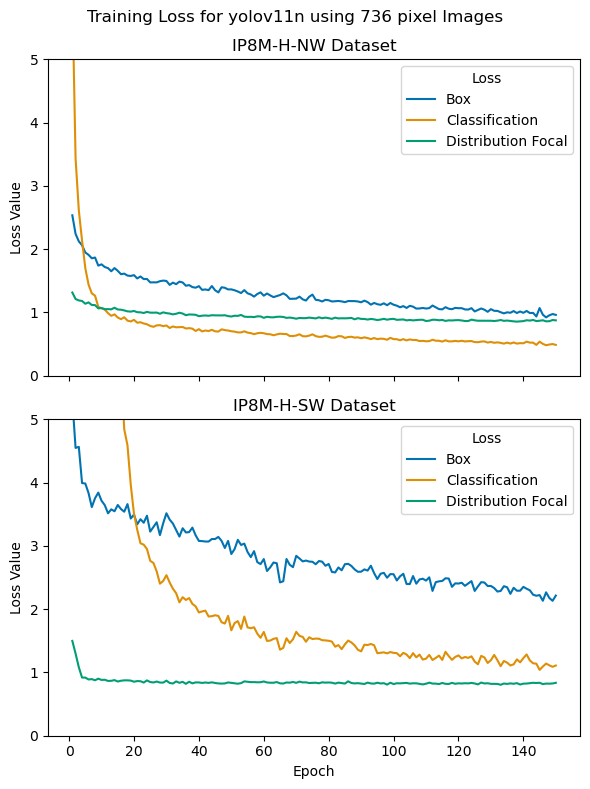

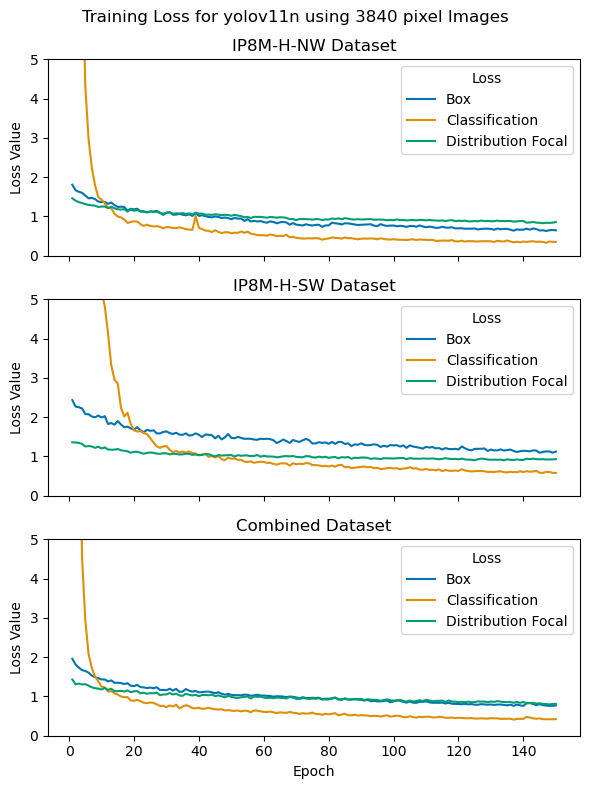

In [22]:
for model in ["yolov11n"]: #, "yolov11s", "yolov11m"]:
    for imgsize in [736, 3840]: #[736, 1440, 2880, 3840 ]:
        mask_list = []
        mask_list.append( train_df['Model Name'] == model )
        mask_list.append( train_df['Image Size (px)'] == imgsize )
        
        cameras = train_df[ join_mask(mask_list) ]['Camera'].unique().tolist()
        if len(cameras) == 1:
            continue
            
        fig, axs = plt.matplotlib.pyplot.subplots(nrows=len(cameras), ncols=1, sharex=True, sharey=False, figsize=(6,8))
        for i, camera in enumerate(cameras):
            camera_name = camera if camera[0].isupper() else camera.capitalize()
            mask_list.append((train_df['Camera'] == camera))
            current_df = train_df[ join_mask( mask_list ) ]
        
            melt_df = pd.melt(current_df, id_vars=['Epoch'], value_vars=plot_metrics, var_name='Loss', value_name='Loss Value')
            #display(melt_df)
            axs[i] = sns.lineplot(data=melt_df, x='Epoch', y='Loss Value', palette='colorblind', hue='Loss', ax=axs[i])
            axs[i].set_title(f"{camera_name} Dataset") 
        
            mask_list.pop()
            axs[i].set_ylim([0,5])
        
        fig.suptitle(f"Training Loss for {model} using {imgsize} pixel Images")
        fig.tight_layout()
        plt.savefig(os.path.join("/data/mtmoore/school/CSiML_AI395T/final_project/plots", f"training_losses_camera_model_{imgsize}px_{model}.png"))


# Plot Epoch Time

,Camera,Model Name,Image Size (px),Mean Duration
0,IP8M-H-NW,yolov11n,736,20.527800
1,IP8M-H-NW,yolov11n,1440,27.884400
2,IP8M-H-NW,yolov11n,2880,81.206667
3,IP8M-H-NW,yolov11n,3840,272.951133
4,IP8M-H-NW,yolov11s,736,24.755667
5,IP8M-H-NW,yolov11s,1440,49.944667
6,IP8M-H-NW,yolov11s,2880,145.587333
7,IP8M-H-NW,yolov11s,3840,485.746733
8,IP8M-H-NW,yolov11m,736,25.458813
9,IP8M-H-NW,yolov11m,1440,65.326600


,Camera,Model Name,Image Size (px),Mean Duration
12,IP8M-H-SW,yolov11n,736,4.385989
13,IP8M-H-SW,yolov11n,1440,8.436000
14,IP8M-H-SW,yolov11n,2880,41.667933
15,IP8M-H-SW,yolov11n,3840,143.179333
16,IP8M-H-SW,yolov11s,736,4.617893
17,IP8M-H-SW,yolov11s,1440,14.442667
18,IP8M-H-SW,yolov11s,2880,76.673333
19,IP8M-H-SW,yolov11s,3840,256.283600
20,IP8M-H-SW,yolov11m,736,8.556133
21,IP8M-H-SW,yolov11m,1440,29.935467


,Camera,Model Name,Image Size (px),Mean Duration
24,combined,yolov11n,736,NaN
25,combined,yolov11n,1440,101.896667
26,combined,yolov11n,2880,122.598000
27,combined,yolov11n,3840,256.357333
28,combined,yolov11s,736,NaN
29,combined,yolov11s,1440,72.772667
30,combined,yolov11s,2880,112.930667
31,combined,yolov11s,3840,231.162000
32,combined,yolov11m,736,NaN
33,combined,yolov11m,1440,NaN


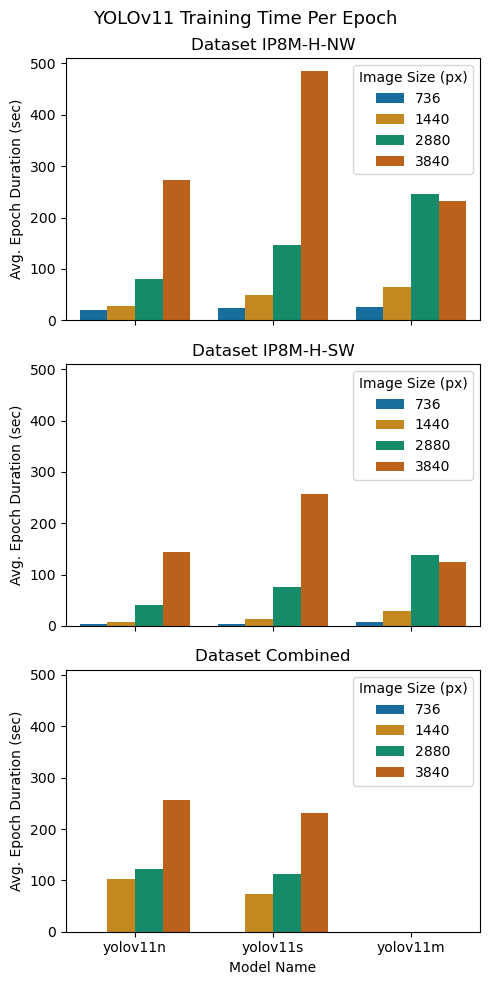

In [26]:
epoch_duration_mean_df = train_df.groupby(by=["Camera", "Model Name", "Image Size (px)"], observed=False).agg( Mean_Duration=('epoch_duration', 'mean')  ).reset_index()

epoch_duration_mean_df.rename(columns={'Mean_Duration': "Mean Duration"}, inplace=True)

cameras = epoch_duration_mean_df['Camera'].unique().tolist()
fig, axs = plt.matplotlib.pyplot.subplots(nrows=len(cameras), ncols=1, sharex=True, sharey=True, figsize=(5,10))
for i, camera in enumerate(cameras):
    camera_name = camera if camera[0].isupper() else camera.capitalize()
    
    current_df = epoch_duration_mean_df[ epoch_duration_mean_df['Camera'] == camera ]
    display(current_df)
    axs[i] = sns.barplot(data=current_df, x="Model Name", y="Mean Duration", hue='Image Size (px)', ax=axs[i], palette='colorblind',)
    axs[i].set_title(f"Dataset {camera_name}")
    axs[i].set_ylabel("Avg. Epoch Duration (sec)")
fig.suptitle("YOLOv11 Training Time Per Epoch", fontsize=13)
fig.tight_layout()

plt.savefig(os.path.join("/data/mtmoore/school/CSiML_AI395T/final_project/plots", f"yolo_epoch_training_time.png"))

#for camera in train_df['Camera'].unique().tolist():
#    mask_list.append(train_df['Camera'] == camera) 
    
#    # iterate over model
#    for model in train_df[join_mask(mask_list)]['Model Name'].unique().tolist(): 
#        mask_list.append( train_df['Model Name'] == model )
        
#        # iterate over model
#        for imgsize in train_df[join_mask(mask_list)]['Image Size (px)'].unique().tolist(): 
#            mask_list.append( train_df['Image Size (px)'] == imgsize )